In [1]:
import gym
import safe_agents as sa
import numpy as np
import skopt
import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


In [2]:
env = gym.make('LunarSafe-v0')

In [3]:
"""
s[0] is the horizontal coordinate
s[1] is the vertical coordinate
s[2] is the horizontal speed
s[3] is the vertical speed
s[4] is the angle
s[5] is the angular speed
s[6] 1 if first leg has contact, else 0
s[7] 1 if second leg has contact, else 0

action 1 do nothing
action 2 fire left orientation engine
action 3fire main engine
action 4 fire right orientation engine.
"""

def heuristic(env, s):
    angle_targ = s[0]*0.5 + s[2]*1.0         # angle should point towards center
    if angle_targ > 0.4: angle_targ = 0.4    # more than 0.4 radians (22 degrees) is bad
    if angle_targ < -0.4: angle_targ = -0.4
    hover_targ = 0.55*np.abs(s[0])           # target y should be proportional to horizontal offset

    angle_todo = (angle_targ - s[4]) * 0.5 - (s[5])*1.0
    hover_todo = (hover_targ - s[1])*0.5 - (s[3])*0.5

    if s[6] or s[7]:  # legs have contact
        angle_todo = 0
        hover_todo = -(s[3])*0.5  # override to reduce fall speed, that's all we need after contact

    if env.continuous:
        a = np.array([hover_todo*20 - 1, -angle_todo*20])
        a = np.clip(a, -1, +1)
    else:
        a = 0
        if hover_todo > np.abs(angle_todo) and hover_todo > 0.05: a = 2
        elif angle_todo < -0.05: a = 3
        elif angle_todo > +0.05: a = 1
    return a


In [58]:
def train(env, episodes=1000, render=False):
    state_size = env.observation_space.shape[0] - 1 # minus for safety
    action_size = env.action_space.n
    scores, safety = [], []
    for e in range(episodes):
        done = False
        score = 0
        state = env.reset()
        safe_ep = []

        while not done:
            # get action for the current state and go one step in environment
            action = heuristic(env, state)
            next_state, reward, done, info = env.step(action)
#            env.render(mode='human')
            safe_ep.append(state[-1])
            # if an action make the episode end, then gives penalty of -100
            reward = reward if not done or score == 499 else -100

            score += reward
            state = next_state

            if done:
                score = score if score == 500 else score + 100
                scores.append(score)
                print(
                    f"episode: {e}  | "
                    f"score: {score}  | "
                )

                # if the mean of scores of last 10 episode is bigger than 490
                # stop training
                if np.mean(scores[-min(10, len(scores)) :]) > 490:
                    return
        safety.append(safe_ep)
    return scores, safety

In [ ]:
scores1, safety1 = train(env, episodes=300)

episode: 0  | score: 106.96354774305169  | 
episode: 1  | score: -177.53201120649592  | 
episode: 2  | score: 25.305387547305372  | 
episode: 3  | score: 67.68686323110259  | 
episode: 4  | score: 78.91184420842595  | 
episode: 5  | score: 104.1639129464426  | 
episode: 6  | score: 59.33159584830102  | 
episode: 7  | score: 56.000984303740836  | 
episode: 8  | score: 67.2431256712529  | 
episode: 9  | score: 82.76076157270401  | 
episode: 10  | score: 39.21406537308562  | 
episode: 11  | score: 43.93310439337782  | 
episode: 12  | score: 64.4060239320309  | 
episode: 13  | score: -32.58850602178525  | 
episode: 14  | score: 96.57240244142056  | 
episode: 15  | score: 58.57274634829284  | 
episode: 16  | score: 82.68322014980964  | 
episode: 17  | score: 54.725954440689776  | 
episode: 18  | score: 48.96399737936488  | 
episode: 19  | score: 86.12930291075841  | 
episode: 20  | score: -171.42663868366589  | 
episode: 21  | score: 53.47184079596872  | 
episode: 22  | score: -19.519515384

In [6]:
agent = sa.agents.DQNAgent(env)
scores2, safety2 = agent.train(episodes=100)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
episode: 0  | score: -7.774585708900958  | memory: 118 | epsilon: 0.9882687638496386
episode: 1  | score: -61.54975620083684  | memory: 227 | epsilon: 0.9775545969005506

episode: 2  | score: 6.9531424763416965  | memory: 291 | epsilon: 0.9713179143142632
episode: 3  | score: -63.22533205424645  | memory: 364 | epsilon: 0.9642527594680443
episode: 4  | score: -107.89173479377268  | memory: 427 | epsilon: 0.9581967607057171
episode: 5  | score: 4.550932523750092  | memory: 489 | epsilon: 0.9522740241044765
episode: 6  | score: 105.55813324614995  | memory: 552 | epsilon: 0.9462932579052122
episode: 7  | score: -93.29623523933961  | memory: 618 | epsilon: 0.9400679771591576
episode: 8  | score: -35.26966800635614  | memory: 713 | epsilon: 0.9311791755905489
episode: 9  | score: -84.45860334163058  | memory: 781 | epsilon: 0.9248683228669151
episode: 10  | score: -258.84597784973846  | memory: 870 | epsilon: 

/usr/local/Caskroom/miniconda/base/envs/test-framework/lib/python3.6/site-packages/seaborn/regression.py:580: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


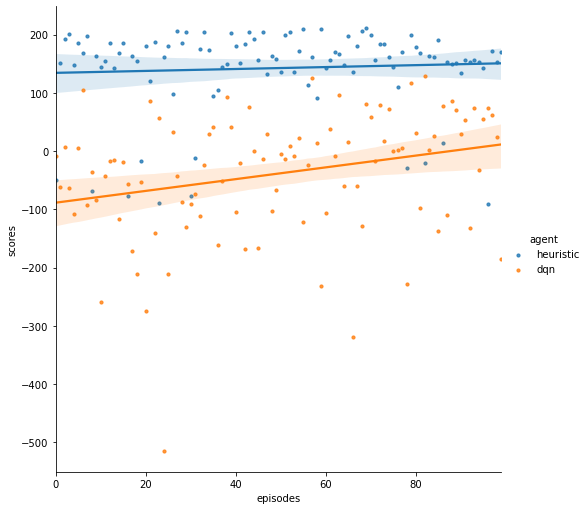

In [7]:
agents = ["heuristic", "dqn"]
scores = scores1 + scores2
safeties = safety1 + safety2
sa.utils.plot_multi_scores(agents, scores)

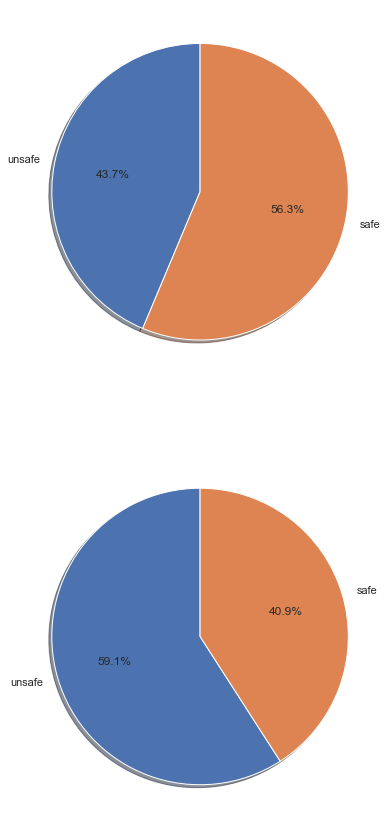

In [56]:
import itertools
merged = list(itertools.chain.from_iterable(safety1))
agents = {'heuristic': merged, 'dqn': safety2}
sa.utils.plot_multi_safety(agents)

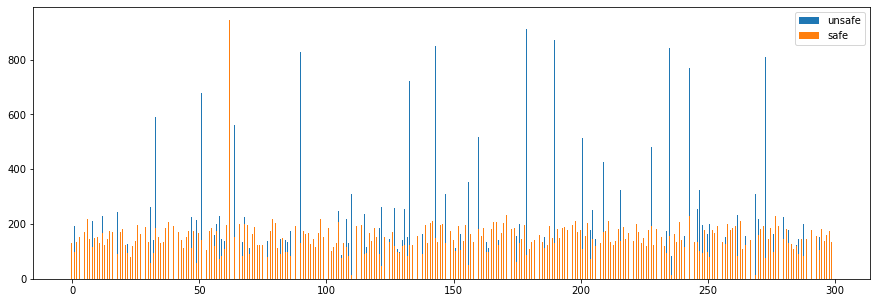

In [42]:
s = [(i.count(0), i.count(1)) for i in safety1]
unsafe = [i[0] for i in s]
safe = [i[1] for i in s]
labels = [str(i) for i in range(len(safety1))]
x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars
fig, ax = plt.subplots(figsize=(15,5))
p1 = ax.bar(x - width/2, unsafe, width, label='unsafe')
p2 = ax.bar(x - width/2, safe, width, label='safe')
ax.legend()
